In [14]:
import warnings
warnings.filterwarnings('ignore')
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics(
    ip))
%autonotify -a 30
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
import logging
import sys
def get_logger(name="model"):
    """Set up logger."""
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter(
        "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

    return logger
logger = get_logger()

<IPython.core.display.Javascript object>

The task is to classify the reuters dataset into the categories attached to each document. As this is a very well used dataset, there are countless example datasets associated with various platforms. 

But as the assignment starts with "download the Reuters data set", I downloaded the various files locally and loaded the data into something that was usable for machine learning.


In [2]:
!ls -la data/reuters21578/*.sgm

-rw-r--r--@ 1 christina.jenkins  staff  1324350 Dec  4  1996 data/reuters21578/reut2-000.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1254440 Dec  4  1996 data/reuters21578/reut2-001.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1217495 Dec  4  1996 data/reuters21578/reut2-002.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1298721 Dec  4  1996 data/reuters21578/reut2-003.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1321623 Dec  4  1996 data/reuters21578/reut2-004.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1388644 Dec  4  1996 data/reuters21578/reut2-005.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1254765 Dec  4  1996 data/reuters21578/reut2-006.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1256772 Dec  4  1996 data/reuters21578/reut2-007.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1410117 Dec  4  1996 data/reuters21578/reut2-008.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1338903 Dec  4  1996 data/reuters21578/reut2-009.sgm
-rw-r--r--@ 1 christina.jenkins  staff  1371071 Dec  4  1996 data/reut

21 files, each ~ the same size, except the last one which is ~ half the size. Now, how many have topics:

In [3]:
!grep \<TOPICS\>\<D\> data/reuters21578/*.sgm | wc -l


   11367


A substantial number! Great, let's load them. For this I created a parse class, and then a function to instantiate and run the class for all files within the data/reuters21578 folder. 

In [4]:
from reuters import load_data

df = load_data("data/reuters21578/")

data/reuters21578/reut2-004.sgm
data/reuters21578/reut2-010.sgm
data/reuters21578/reut2-011.sgm
data/reuters21578/reut2-005.sgm
data/reuters21578/reut2-013.sgm
data/reuters21578/reut2-007.sgm
data/reuters21578/reut2-006.sgm
data/reuters21578/reut2-012.sgm
data/reuters21578/reut2-016.sgm
data/reuters21578/reut2-002.sgm
data/reuters21578/reut2-003.sgm
data/reuters21578/reut2-017.sgm
Failed to read data/reuters21578/reut2-017.sgm as utf-8
Cannot find date patter in: 31-MAR-1987 605:12:19.12
data/reuters21578/reut2-001.sgm
data/reuters21578/reut2-015.sgm
data/reuters21578/reut2-014.sgm
data/reuters21578/reut2-000.sgm
data/reuters21578/reut2-019.sgm
data/reuters21578/reut2-018.sgm
data/reuters21578/reut2-020.sgm
data/reuters21578/reut2-008.sgm
data/reuters21578/reut2-009.sgm
data/reuters21578/reut2-021.sgm


Successfully loaded all the files except `data/reuters21578/reut2-017.sgm`, which if I had more time I would definitely investigate. But let's take a look at the data before I spend that time to see if I have a big enough sample size without it.

Since I was instructed to use the lewis_split for splitting training vs. testing, let's take a look at what kind of samples we're talking about within those parameters:


In [5]:
df.lewis_split.value_counts()

TRAIN       14668
TEST         6188
NOT-USED      722
Name: lewis_split, dtype: int64

Decent sample size, and note the 'NOT-USED' category. I will remove those while cleaning the data. 

In [6]:
df.head()

,old_id,new_id,has_topics,date,topics,places,people,orgs,exchanges,companies,title,dateline,body,author,cgi_split,lewis_split
0,8914,4001,True,1987-03-11 18:04:17.590,,canada,,,,,INCO SEES NO MAJOR IMPACT FROM DOW REMOVAL,"TORONTO, March 11 -",Inco Ltd said it did not expect its\nearlier r...,,TRAINING-SET,TRAIN
1,8915,4002,True,1987-03-11 18:06:47.220,,usa,,,,,FORMER EMPIRE OF CAROLINA <EMP> EXEC SENTENCED,"NEW YORK, March 11 -","Mason Benson, former president and\nchief oper...",,TRAINING-SET,TRAIN
2,8916,4003,True,1987-03-11 18:09:39.660,,usa,,,,,"DOCTORS FIND LINK BETWEEN AIDS, SMALLPOX VIRUS","BOSTON, March 11 -",In a discovery that could complicate the\nsear...,,TRAINING-SET,TRAIN
3,8917,4004,True,1987-03-11 18:13:59.930,,usa,,,,,BIRTH CONTROL PILLS HELP PREVENT CANCER - STUDY,"BOSTON, March 11 -",Doctors at the Centers for Disease\nControl in...,,TRAINING-SET,TRAIN
4,8918,4005,True,1987-03-11 18:14:49.930,interest,usa,,,,,U.S. ECONOMIC DATA KEY TO DEBT FUTURES OUTLOOK,"CHICAGO, March 11 -",U.S. economic data this week could be\nthe key...,"By Brad Schade, Reuters",TRAINING-SET,TRAIN


Because I am using TOPICS as the target, which it turns out is not present for every article:

In [7]:
df.topics.value_counts()

            10211
earn         3972
acq          2423
money-fx      682
crude         543
            ...  
wool            1
rand            1
fishmeal        1
barley          1
cruzado         1
Name: topics, Length: 83, dtype: int64

To the tune of 10211 articles. But, as including them adds nothing (without doing some imputation that I wish I had more time for). 

It's also notable that the dataset is very imbalanced, which can be tricky for multi-label classification. To offset some of this, I only use topics that are used more than 100 times. This is an entirely arbitrary cutoff to simplify this case study. If this were a real life work assignment, I would consult my stakeholders about whether all the topics were important, or whether this cutoff is appropriate. 

In [8]:
df[(df.lewis_split != 'NOT-USED') & 
    (df.groupby('topics').topics.transform('count')>100) & 
   (df.topics != '')].lewis_split.value_counts()


TRAIN    6858
TEST     2634
Name: lewis_split, dtype: int64

In [9]:
df[(df.lewis_split != 'NOT-USED') & 
    (df.groupby('topics').topics.transform('count')>100) & 
   (df.topics != '')].lewis_split.shape

(9492,)

I recently did some research on sample size and various ml algorithms and to my surprise, most of them fair fine with 9000 samples (I assumed the threshold would be much higher). I think I'm ok to proceed. 

In [10]:
df[(df.lewis_split != 'NOT-USED') & 
    (df.groupby('topics').topics.transform('count')>100) & 
   (df.topics != '')].topics.value_counts()

earn            3950
acq             2347
money-fx         628
grain            499
crude            491
trade            424
interest         319
ship             193
money-supply     164
sugar            133
coffee           122
gold             114
gnp              108
Name: topics, dtype: int64

I've also reduced the number of topics to 13, and still have imbalanced data. But with text data, which usually has a fairly broad feature space, this shouldn't be problematic. 

In [15]:
from clean_data import setup_split_data

train_data, test_data = setup_split_data(logger, df)

2020-08-13 10:49:32,243 - model - INFO - Data cleaned
2020-08-13 10:49:32,257 - model - INFO - Split into training and testing complete
2020-08-13 10:49:32,258 - model - INFO - Training data size: (6858, 17), test data size (2634, 17)


## Simple network approach

I have been playing around with neural networks lately. This assignment seemed like a great time to stretch my legs and try those techniques out. 

First I need to transform the data, starting with the labels. First I map them to numbers and then encode them using to_categorical, which generates a one hot encoding array.

In [17]:
from clean_data import map_topics

train_labels_encoded, test_labels_encoded = map_topics(logger, train_data, test_data)


2020-08-13 10:50:01,611 - model - INFO - There are 13 lables
2020-08-13 10:50:01,792 - model - INFO - Training and testing labels mapped.


I then tokenize the data. I merged the title and body into one string for each document. I considered, using the remaining information (places, people, orgs, companies, author), but ran out of time to check if they would add lift.

I then used tfidf to tokenize the text. The function also returns the tokenizer, because I like to inspect the words and their counts, to get a feel for the corpus.

In [19]:
from clean_data import tokenize_data

xt_train, xt_test, t = tokenize_data(logger, train_data, test_data)

2020-08-13 10:50:23,325 - model - INFO - Tokenizing corpus.
2020-08-13 10:50:24,151 - model - INFO - Top 10 words in corpus: ['u', 's', 'economic', 'data', 'key', 'to', 'debt', 'futures', 'outlook', 'this']
2020-08-13 10:50:27,322 - model - INFO - Tokenizing is complete.


In [21]:
t.word_counts

OrderedDict([('u', 5149),
             ('s', 4907),
             ('economic', 851),
             ('data', 337),
             ('key', 205),
             ('to', 30466),
             ('debt', 748),
             ('futures', 284),
             ('outlook', 140),
             ('this', 2888),
             ('week', 1208),
             ('could', 1231),
             ('be', 5286),
             ('the', 57209),
             ('in', 23426),
             ('determining', 13),
             ('whether', 282),
             ('interest', 1297),
             ('rate', 1520),
             ('break', 62),
             ('out', 642),
             ('of', 31175),
             ('a', 21048),
             ('3', 4368),
             ('1', 8578),
             ('2', 5535),
             ('month', 909),
             ('trading', 668),
             ('range', 211),
             ('financial', 860),
             ('analysts', 824),
             ('said', 21520),
             ('although', 269),
             ('market', 2320),
         

Now that I have transformed data and labels, I have to compile my neural network.

I have three layers, use categorical crossentropy as a loss function (which is ideal for multilabel classification). 

I used accuracy as the metric.

In [22]:
from classifier import compile_model

clf = compile_model(logger)


2020-08-13 10:51:10,078 - model - INFO - Compiling model
2020-08-13 10:51:10,172 - model - INFO - The network has 3 layers
2020-08-13 10:51:10,172 - model - INFO - The network loss function is categorical_crossentropy


I took 1000 samples from the training set for validation.

In [23]:
from clean_data import split_val

x_val, partial_x_train, y_val, partial_y_train = split_val(logger, xt_train, train_labels_encoded)


2020-08-13 10:51:51,743 - model - INFO - Returning train and val set for training.


In [24]:
results = clf.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   validation_data=(x_val,y_val))


Train on 5858 samples, validate on 1000 samples
Epoch 1/20
5858/5858 [==============================] - 1s 156us/step - loss: 0.5576 - accuracy: 0.8657 - val_loss: 0.2950 - val_accuracy: 0.9290
Epoch 2/20
5858/5858 [==============================] - 1s 126us/step - loss: 0.0890 - accuracy: 0.9780 - val_loss: 0.2900 - val_accuracy: 0.9410
Epoch 3/20
5858/5858 [==============================] - 1s 129us/step - loss: 0.0446 - accuracy: 0.9877 - val_loss: 0.3780 - val_accuracy: 0.9450
Epoch 4/20
5858/5858 [==============================] - 1s 127us/step - loss: 0.0329 - accuracy: 0.9901 - val_loss: 0.4167 - val_accuracy: 0.9430
Epoch 5/20
5858/5858 [==============================] - 1s 103us/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.5184 - val_accuracy: 0.9340
Epoch 6/20
5858/5858 [==============================] - 1s 107us/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.5910 - val_accuracy: 0.9350
Epoch 7/20
5858/5858 [==============================] - 1s 109us/step - loss

Accuracy on the training set rapidly increases, but in the validation set it kind of stagnates. If I were in a position where we needed to keep training costs down (if for example we were training on AWS sagemaker, or on a GPU cloud instance), then I would  cut down on the epochs. 

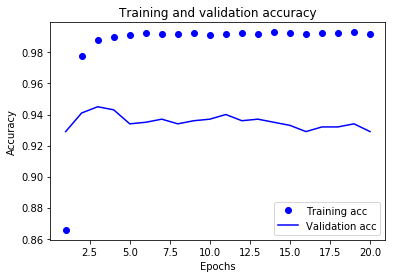

In [28]:
import matplotlib.pyplot as plt

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
test_loss, test_accuracy = clf.evaluate(xt_test, test_labels_encoded)
test_accuracy

2634/2634 [==============================] - 0s 128us/step


0.9244495034217834

92% accuracy on the test data isn't too bad.